In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

**helper function to capture image**

In [4]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # save image
  cv2.imwrite(filename, img)

  return filename

**below code will ask you your name , please enter your name and hit Enter then camera will open , you have capture your image by clicking on capture option.**

please Enter your name here : Mayur


<IPython.core.display.Javascript object>

Saved to Mayur/Mayur.jpg


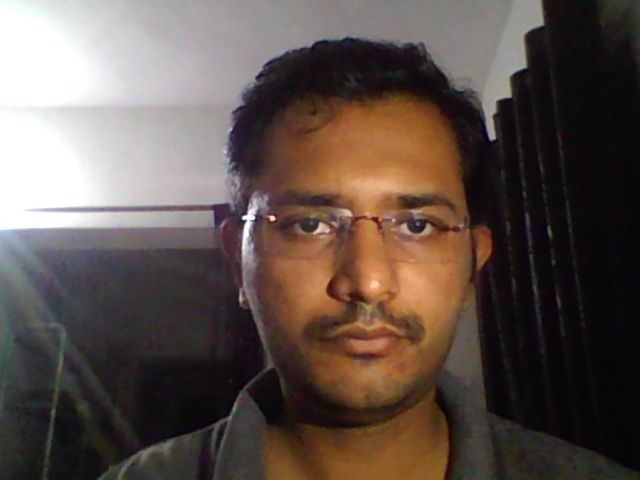

In [5]:
import os
try:
  enter_name = input("please Enter your name here : ")
  if not os.path.exists(enter_name):
    os.makedirs(enter_name)

  filename = take_photo(os.path.join(enter_name,'{}.jpg'.format(enter_name))) #calling function here
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**Face Recognition part**

In [6]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 9.0 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=0d688abf234823574df195f5cba245d4c4d5bde46c8370ebcd211fa4dbcb5e16
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [7]:
import cv2
import numpy as np
import face_recognition
import pickle

**create and save features (embeddings) of face**

In [9]:
import glob
encodeList = []

for img in glob.glob(os.path.join(enter_name,'*')):
  img_array = cv2.imread(img)
  img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
  encode = face_recognition.face_encodings(img)[0]
  encodeList.append(encode)
  
pickle.dump(encodeList,open('features.pickle', 'wb')) 
print("embeddings are created successfully")  

embeddings are created successfully


**This is helper function provided by colab to access our webcam**

In [10]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

**After running below code your webcam will open and it will show bounding box along with your name**

In [11]:
classNames = [enter_name]

encodeListKnown = pickle.load(open('/content/features.pickle','rb'))

print('Encoding Complete')

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    imgS = cv2.resize(frame, (0, 0), None, 0.25, 0.25)
    imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

    facesCurFrame = face_recognition.face_locations(imgS)
    encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

    for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
        matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
        #print("matches:",matches)
        faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)
        #print("faceDis:",faceDis)
        matchIndex = np.argmin(faceDis)

        if matches[matchIndex]:
            name = classNames[matchIndex].upper()
            y1, x2, y2, x1 = faceLoc
            y1, x2, y2, x1 = y1 * 4, x2 * 4, y2 * 4, x1 * 4
            cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.rectangle(bbox_array, (x1, y2 - 35), (x2, y2), (0, 255, 0), cv2.FILLED)
            cv2.putText(bbox_array, name, (x1 + 6, y2 - 6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)

        else:
            name = "Unknown"
            y1, x2, y2, x1 = faceLoc
            y1, x2, y2, x1 = y1 * 4, x2 * 4, y2 * 4, x1 * 4
            cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.rectangle(bbox_array, (x1, y2 - 35), (x2, y2), (0, 255, 0), cv2.FILLED)
            cv2.putText(bbox_array, name, (x1 + 6, y2 - 6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
          
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    

Encoding Complete


<IPython.core.display.Javascript object>